# Array seismology tools correcting for a circular wavefront

Many array seismology techniques assume a plane wavefront. This is fine for small arrays which sample such a small part of the wavefield and the assumption holds. For larger arrays, spread over several degrees in distance, this assumption breaks down and affects the accuracy of these techniques. 

Ward et al. (in prep) correct for this curvature in the beamforming methodology they use to measure the backazimuth (direction) and horizontal slowness (inclination) of an arriving wave at an array of stations:


## Theory

This explanation assumes you are familiar with traditional beamforming methodology and its application to global seismology.

Here, we provide a correction for a circular wavefront by altering the way the travel times are calculated. 
We calculate the radial distance over a spherical Earth from the event to each staion in the array using the haversine formula. These distances are multiplied by an angular slowness value to calculate the travel times. Shifting, stacking and measuring the power value stays the same. 

To search over backazimuth, the event location is moved keeping the epicentral distance to the centre of the array constant. At this new location, the distances are calculated again and and times calculated. 

<img src="Images/circ_explanation.png" alt="Drawing" style="width: 600px;"/>


## Uses and functions

We apply this correction in two techniques the first being where you grid search over a range of backazimuths and horizontal slownesses. The other where you measure how the power varies in time with backazimuth and horizontal slowness (vespagram). 

In addition to this correction, we provide useful functions for utility use for extracting information from and Obspy stream of sac files. 


In [1]:
# Add the package to Python's search path, assuming we are running this notebook in the 'examples' folder
import sys
sys.path.append("..")

In [2]:
import obspy
import numpy as np
import matplotlib.pyplot as plt
# utilities class
from circ_array.array_info import array
# plotting class
from circ_array.array_plotting import plotting as Plotting
# Numba-compiled functions
from circ_array.shift_stack import linear_stack_baz_slow, pws_stack_baz_slow, shift_traces
from circ_array.beamforming_xy import BF_XY_all
from circ_array.beamforming_polar import BF_Pol_all

<Figure size 640x480 with 0 Axes>

## Notes

The files read into an Obspy stream object need to be sac files with headers for station & event location, travel time predictions and labels in tn and ktn respectively and distance headers populated.

In [3]:
# read in traces from example events:
st = obspy.read('data/19970525/*SAC')


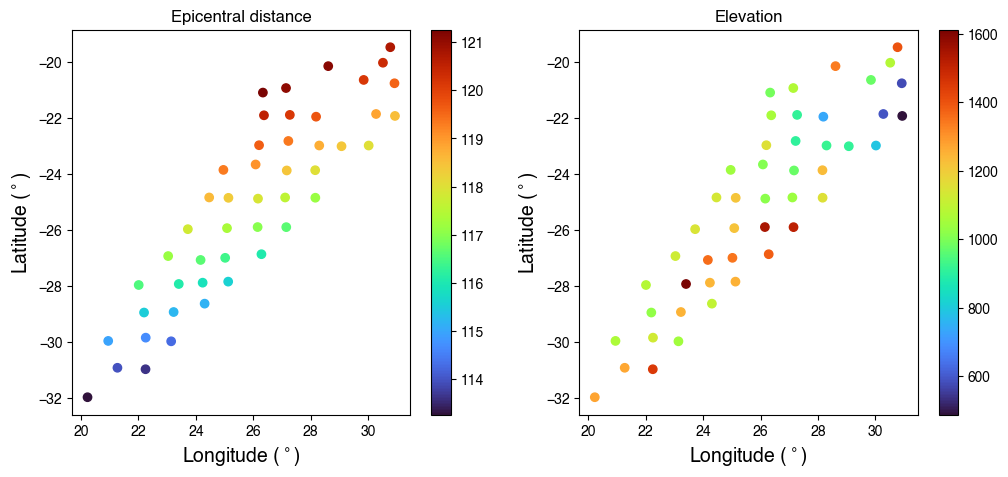

In [4]:
## get array information 

# Create and array object which holds all the traces
arr = array(st)

stations = arr.stations()
geometry = arr.geometry()

centre_x, centre_y, centre_z = arr.geometry(return_center=True)

distances = arr.distances()
mean_dist = np.mean(distances)

# for fun lets plot the stations coloured by their distance from the event and with elevation
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
dist = ax.scatter(geometry[:,0], geometry[:,1], c = distances)
ax.set_title("Epicentral distance")
ax.set_xlabel("Longitude ($^\circ$)", fontsize=14)
ax.set_ylabel("Latitude ($^\circ$)", fontsize=14)
plt.colorbar(dist)
ax = fig.add_subplot(122)
ele = ax.scatter(geometry[:,0], geometry[:,1], c = geometry[:,2])
ax.set_title("Elevation")
ax.set_xlabel("Longitude ($^\circ$)", fontsize=14)
ax.set_ylabel("Latitude ($^\circ$)", fontsize=14)
plt.colorbar(ele)
plt.show()

## Note

The next cell will show how you can recover information about predicted arrival times from the SAC files easily. For this to work, the headers tn and ktn need to have the predicted travel times and the associated phase name in the headers respectively. 

In [5]:
# target phase
phase = "SKS"
# recover the predicted time for this phase and the other phases stored 
Target_phase_times, time_header_times = arr.get_predicted_times(phase)

# mean predicted time
print("mean %s time:" %phase, np.mean(Target_phase_times))
print("max %s time:" %phase, np.amax(Target_phase_times))
print("min %s time:" %phase, np.amin(Target_phase_times))


mean SKS time: 1469.2877
max SKS time: 1481.9824
min SKS time: 1452.8536


In [6]:
# From a list of phases, we can predict properties of those phases at the mean station location using the function:

phases = ['SKS','SKKS','ScS','Sdiff','SKKKS','sSKS','PS']

predictions = arr.pred_baz_slow(phases=phases)

# output is:
# Phase slowness backazimuth slow_x(backazimuth) slow_y(backazimuth) slow_x(azimuth) slow_y(azimuth) distance time
print(np.matrix(predictions), '\n')

# given our target phase, we can recover the predictions

row = np.where((predictions == phase))[0]
P, S, BAZ, PRED_BAZ_X, PRED_BAZ_Y, PRED_AZ_X, PRED_AZ_Y, DIST, TIME = predictions[row, :][0]
print("Predictions:",P,S,BAZ,TIME)


[['SKS' '3.6202543240649625' '155.09474799676082' '1.5' '-3.3' '-1.5'
  '3.3' '117.57019735235569' '1469.1089511346458']
 ['SKKS' '6.606005163849781' '155.09474799676082' '2.8' '-6.0' '-2.8'
  '6.0' '117.57019735235569' '1546.6902323741185']
 ['SKKS_Major' '2.8300084543747746' '335.0947479967608' '-1.2' '2.55'
  '1.2' '-2.55' '117.57019735235569' '2127.877096015108']
 ['Sdiff' '8.360674549036386' '155.09474799676082' '3.5' '-7.6' '-3.5'
  '7.6' '117.57019735235569' '1600.7986993060151']
 ['SKKKS' '7.173488745886091' '155.09474799676082' '3.0' '-6.5' '-3.0'
  '6.5' '117.57019735235569' '1557.2330539107863']
 ['SKKKS_Major' '4.8704957855634' '335.0947479967608' '-2.05' '4.4'
  '2.05' '-4.4' '117.57019735235569' '2315.4934505316614']
 ['sSKS' '3.6848842266048414' '155.09474799676082' '1.55' '-3.35' '-1.55'
  '3.35' '117.57019735235569' '1613.4650937060346']
 ['PS' '8.932200060083796' '155.09474799676082' '3.75' '-8.1' '-3.75'
  '8.1' '117.57019735235569' '1753.0155211492304']] 

Predictio

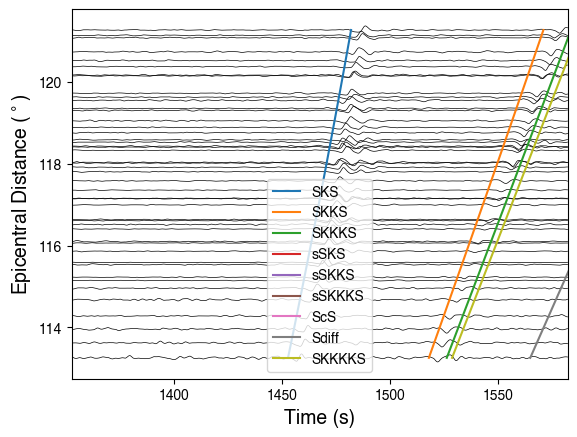

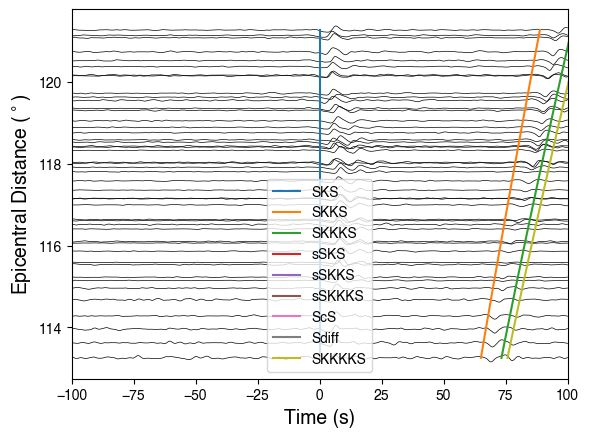

In [7]:
fig, ax = plt.subplots()

# Plotting record sections is a very useful step for understanding your data
# we provide a function to do this
tmin = -100
tmax = 100
# this will draw a window around your arrival and plot it
p = Plotting(ax)
p.plot_record_section_SAC(st=arr.stream, phase=phase, tmin=tmin, tmax=tmax, align=False)

# you can also align the traces
fig, ax = plt.subplots()
p = Plotting(ax)
p.plot_record_section_SAC(st=arr.stream, phase=phase, tmin=tmin, tmax=tmax, align=True)

# Note: this is used in the manual time window picking function: 
# c.pick_tw(stream, phase, tmin=150, tmax=150, align = False)

## Note 

The next cell assumes the headers nzyear, nzjday, nzhour etc is populated with the event origin time


In [8]:
# Using the predicted times we can trim the traces 
# first need the event time
event_time = arr.eventtime()


# predicted min and max arrival times:
max_target = np.amax(Target_phase_times) + 30
min_target = np.amin(Target_phase_times)

stime = event_time + min_target
etime = event_time + max_target

st = st.trim(stime,etime)
st = st.normalize()

## Note

Using this information we can now do exciting things like stack on a given backazimuth and horizontal slowness:

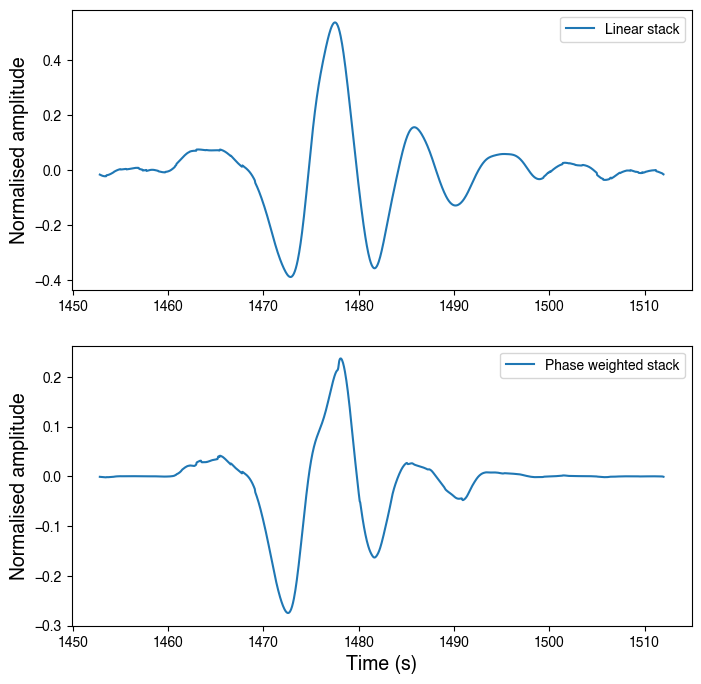

In [9]:
# first need to get traces
Traces = arr.traces()
# also sampling rate
sampling_rate = arr.stream[0].stats.sampling_rate

lin_stack = linear_stack_baz_slow(traces=Traces, sampling_rate=sampling_rate, geometry=geometry,
                              distance=mean_dist, slow=float(S), baz=float(BAZ))

# can also do this for phase weighted stack

Phase_traces = arr.phase_traces()

pws_stack = pws_stack_baz_slow(traces=Traces, phase_traces=Phase_traces, sampling_rate=sampling_rate, geometry=geometry,
                              distance=mean_dist, slow=float(S), baz=float(BAZ), degree=2)

nt = min(
    int(np.round((max_target - min_target)*sampling_rate)) + 1,
    len(pws_stack)
)
times = np.linspace(min_target, max_target, nt, endpoint=True)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(211)
ax.plot(times, lin_stack, label='Linear stack')
ax.set_ylabel("Normalised amplitude", fontsize=14)
ax.legend(loc='best')
ax = fig.add_subplot(212)
ax.set_xlabel("Time (s)", fontsize=14)
ax.set_ylabel("Normalised amplitude", fontsize=14)
ax.plot(times, pws_stack, label='Phase weighted stack')
ax.legend(loc='best')
plt.show()

# Beamforming grid search over baz and slow

The following will use the above information extracted from the sac files to search over a range of backazimuths and slowness in both a cartesian and polar search. The traces used have been trimmed using absolute time values. After these examples, we show how this can be applied relatively by shifting the traces on a slowness value before conducting the grid search.

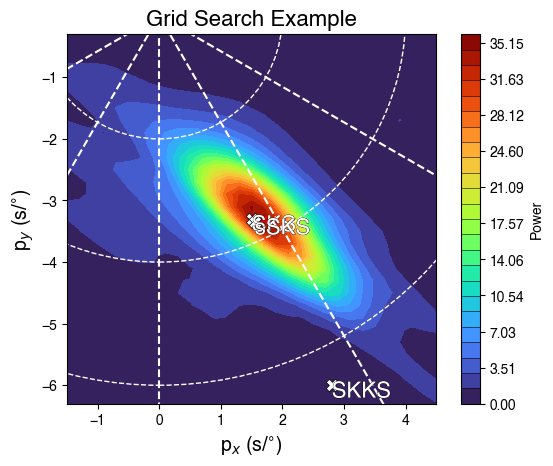

In [10]:
# get our slowness cartesian box
# PRED_BAZ_? is the predicted location of the arrival
box_len = 3

slow_x_min = round(float(PRED_BAZ_X) - box_len, 2)
slow_x_max = round(float(PRED_BAZ_X) + box_len, 2)
slow_y_min = round(float(PRED_BAZ_Y) - box_len, 2)
slow_y_max = round(float(PRED_BAZ_Y) + box_len, 2)
s_space = 0.2


Lin_arr, PWS_arr, F_arr, Results_arr, peaks = BF_XY_all(
    traces=Traces, phase_traces=Phase_traces, sampling_rate=np.float64(sampling_rate),
    geometry=geometry, distance=mean_dist, sxmin=slow_x_min,
    sxmax=slow_x_max, symin=slow_y_min, symax=slow_y_max, s_space=s_space, degree=2
)
# order of peaks output is:
# Lin
# PWS
# Fstat


# peaks has to be a 2D array so it can plot 
# multiple peaks on the plot if the user wants 
# (i.e. if there are multiple arrivals)
peaks = np.array([peaks[0]])

# plot the output
fig, ax = plt.subplots(1, 1)
p = Plotting(ax)
p.plot_TP_XY(tp=Lin_arr, peaks=peaks, sxmin=slow_x_min, sxmax=slow_x_max, symin=slow_y_min, 
             symax=slow_y_max, sstep=s_space, title="Grid Search Example", predictions=predictions)

s 21
b 61


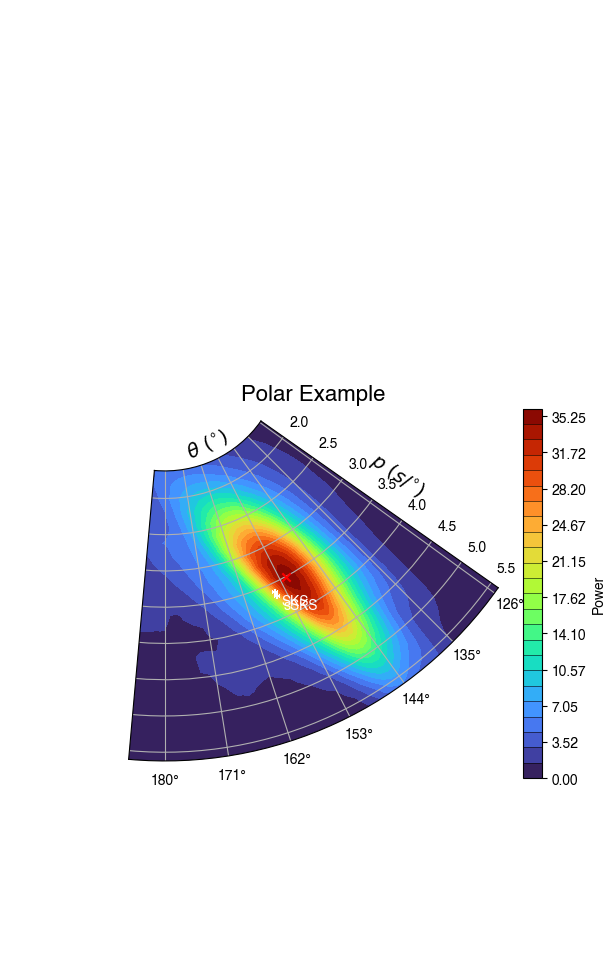

In [11]:
# This can also be done and plotted in polar coordinates!
# get the values you want to search over
slow_min = float(S) - 2
slow_max = float(S) + 2
baz_min = float(BAZ) - 30
baz_max = float(BAZ) + 30
b_space = 1

Lin_arr, PWS_arr, F_arr, Results_arr, peaks = BF_Pol_all(
    traces=Traces, phase_traces=Phase_traces, sampling_rate=np.float64(sampling_rate),
    geometry=geometry, distance=mean_dist, smin=slow_min,
    smax=slow_max, bazmin=baz_min, bazmax=baz_max, s_space=s_space, baz_space=b_space, degree=2
)

peaks = np.array([peaks[0]])

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
p = Plotting(ax)
p.plot_TP_Pol(tp=Lin_arr, peaks=peaks, smin=slow_min, smax=slow_max, bazmin=baz_min, bazmax=baz_max,
              sstep=s_space, bazstep=b_space, contour_levels=30, title="Polar Example", predictions=predictions)




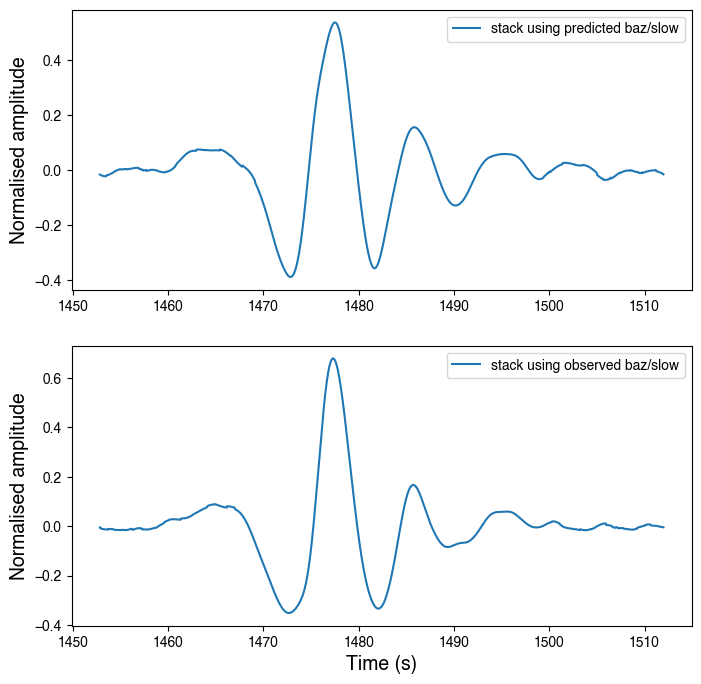

In [12]:
## Now we have the maximum horizontal slowness and backazimuth which we can use to stack the traces

# peaks are a 2D array of baz and slow values 
# when using the polar beamforming function
bazs=peaks[:,0][0]
slows=peaks[:,1][0]

lin_stack_pred = linear_stack_baz_slow(traces=Traces, sampling_rate=sampling_rate, geometry=geometry,
                              distance=mean_dist, slow=float(S), baz=float(BAZ))
lin_stack_obs = linear_stack_baz_slow(traces=Traces, sampling_rate=sampling_rate, geometry=geometry,
                              distance=mean_dist, slow=slows, baz=bazs)

# Plot waveforms
nt = min(
    int(np.round((max_target-min_target)/(1/sampling_rate))) + 1,
    len(lin_stack_pred),
)
times = np.linspace(min_target,max_target,nt,endpoint=True)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(211)
ax.plot(times,lin_stack_pred, label='stack using predicted baz/slow')
ax.set_ylabel("Normalised amplitude", fontsize=14)
ax.legend(loc='best')
ax = fig.add_subplot(212)
ax.set_xlabel("Time (s)", fontsize=14)
ax.set_ylabel("Normalised amplitude", fontsize=14)
ax.plot(times,lin_stack_obs, label='stack using observed baz/slow')
ax.legend(loc='best')
plt.show()

## Beamforming grid search relatively

The following cells show how to use the functions to align the traces on a backazimuth and slowness and then perform the beamforming.

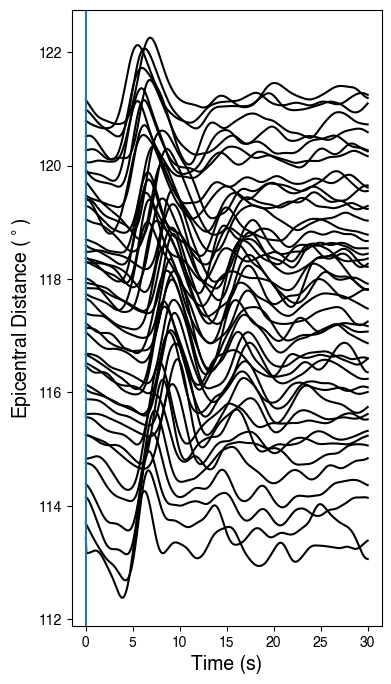

In [13]:
# shift traces on the predicted backazimuth and slowness

shifted_traces = shift_traces(traces=Traces, geometry=geometry, abs_slow=float(S), baz=float(BAZ),
                              distance=float(mean_dist), centre_x=float(centre_x), centre_y=float(centre_y),
                              sampling_rate=sampling_rate)

shifted_phase_traces = shift_traces(traces=Phase_traces, geometry=geometry, abs_slow=float(S), baz=float(BAZ),
                                 distance=float(mean_dist), centre_x=float(centre_x), centre_y=float(centre_y),
                                 sampling_rate=sampling_rate)

# define times around 0 to cut
rel_tmin = 0
rel_tmax = 30


# reminder: TIME is the predicted time of the phase we are interested in
# this is found from "c.pred_baz_slow" shown earlier
pred_point = int(sampling_rate * (float(TIME) - min_target))
point_before= int(pred_point - (rel_tmin * sampling_rate))
point_after= int(pred_point + (rel_tmax * sampling_rate))

cut_shifted_traces = shifted_traces[:,point_before:point_after]
cut_shifted_phase_traces = shifted_phase_traces[:,point_before:point_after]

# plot the cut traces
plot_time = np.linspace(-rel_tmin, rel_tmax, int((rel_tmax + rel_tmin)*sampling_rate))

fig=plt.figure(figsize=(4,8))

for i,tr in enumerate(cut_shifted_traces):
    plt.plot(plot_time, tr + distances[i],color='black')

plt.axvline(0,0,len(cut_shifted_traces))
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Epicentral Distance ($^\circ$)", fontsize=14)
plt.show()


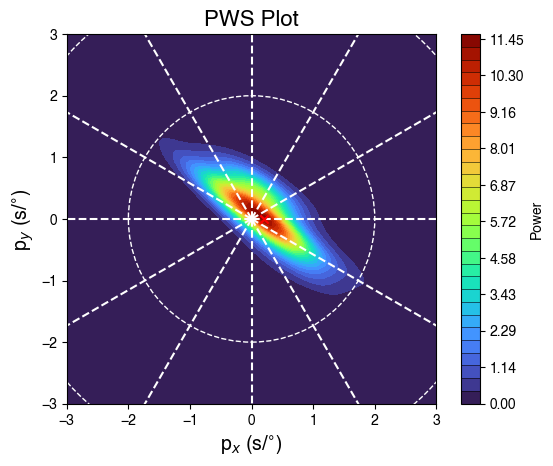

In [14]:
# OK! We have the shifted and cut traces!
# define slowness box
slow_min = -3
slow_max = 3
s_space = 0.05

# run the beamforming!
Lin_arr, PWS_arr, F_arr, Results_arr, peaks = BF_XY_all(
    traces=cut_shifted_traces,
    phase_traces=cut_shifted_phase_traces,
    sampling_rate=np.float64(sampling_rate),
    geometry=geometry,
    distance=mean_dist,
    sxmin=slow_min, sxmax=slow_max,
    symin=slow_min, symax=slow_max,
    s_space=s_space,
    degree=2
)

peaks = np.c_[peaks, np.array(["LIN", "PWS", "F"])]

peaks = peaks[np.where(peaks == "PWS")[0]]
p = Plotting(plt.subplots()[1])
p.plot_TP_XY(tp=PWS_arr, peaks=peaks, sxmin=slow_min, sxmax=slow_max, symin=slow_min, symax=slow_max,
          sstep=s_space, contour_levels=30, title="PWS Plot", predictions=None)


s 61
b 721


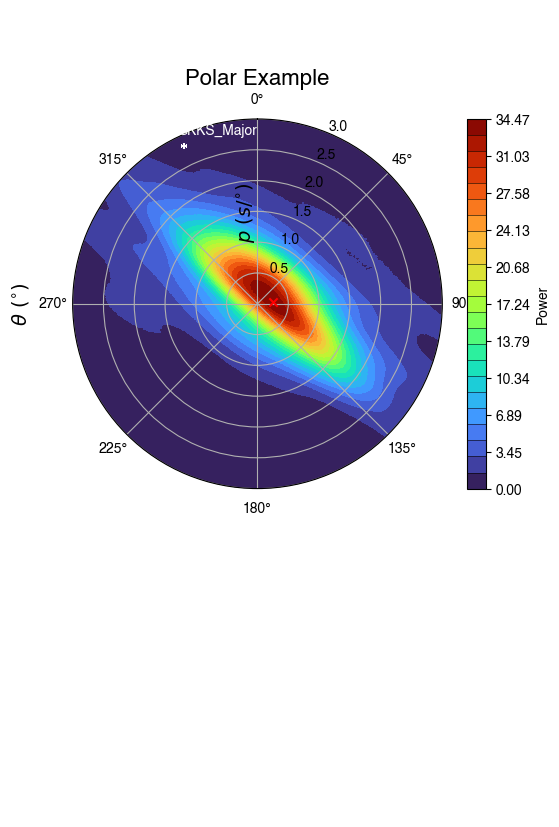

In [15]:
# run the beamforming!
slow_min = 0
slow_max = 3
s_space = 0.05
baz_min = 0
baz_max = 360
b_space = 0.5

Lin_arr, PWS_arr, F_arr, Results_arr, peaks = BF_Pol_all(
    traces=cut_shifted_traces, phase_traces=cut_shifted_phase_traces, 
    sampling_rate=np.float64(sampling_rate), geometry=geometry,
    distance=mean_dist, smin=slow_min, smax=slow_max,
    bazmin=baz_min, bazmax=baz_max, s_space=s_space,
    baz_space=b_space, degree=2
)

peaks = np.array([peaks[0]])

p = Plotting(plt.subplots(subplot_kw={'projection': 'polar'})[1])
p.plot_TP_Pol(tp=Lin_arr, peaks=peaks, smin=slow_min, smax=slow_max, bazmin=baz_min, bazmax=baz_max,
              sstep=s_space, bazstep=b_space, contour_levels=30, title="Polar Example", predictions=predictions)
